In [1]:
import sys, os, re, copy, random
import numpy as np
import scipy as sp
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
import isocor

In [2]:
# Degree of 15N enrichment in 15N-amide Gln:
element_prob_dict = {
    'N_natural': 0.00364,
    'N_enriched': 0.997774
}

# List of metabolites labeled by 15N-amide Gln:
metab_to_correct = {
    'Glutamine pos': {
        'Nmes': 2, # Number of measured isotopologues (excluding m+0), unmeasured isotopologues will be set to zero
        'Niso': 2, # Number of isotope positions (can be extracted from the "ion_formula")
        'ion_formula': 'C5H11N2O3', # Chemical formula in the ionized state i.e. includig extra proton in positive mode
        'tracer_element': '15N', # Element to perform natural abundance correction on
        'charge': 1 # Charge on ion
    },
    'Asparagine pos': {
        'Nmes': 1,
        'Niso': 2,
        'ion_formula': 'C4H9N2O3',
        'tracer_element': '15N',
        'charge': 1
    },
    # AMP = C10H14N5O7P
    # Derived from:
    # 1. Hpx salvage (2x natural abundance N) + 3x natural abundance N (from 2xAsp and Gly)
    # 2. 2x Gln + 3x natural abundance N (from 2xAsp and Gly)
    'AMP pos': {
        'Nmes': 2,
        'Niso': 5,
        'ion_formula': 'C10H15N5O7P',
        'tracer_element': '15N',
        'charge': 1
    },
    'ADP neg': {
        'Nmes': 2,
        'Niso': 5,
        'ion_formula': 'C10H14N5O10P2',
        'tracer_element': '15N',
        'charge': -1
    },
    # UMP = C9H13N2O9P
    # Derived from:
    # 1. Uridine salvage (2x natural abundance N)
    # 2. 1x Gln + 1x natural abundance N (from Asp)
    'UMP neg': {
        'Nmes': 2,
        'Niso': 2,
        'ion_formula': 'C9H12N2O9P',
        'tracer_element': '15N',
        'charge': -1
    },
    'UDP neg': {
        'Nmes': 2,
        'Niso': 2,
        'ion_formula': 'C9H13N2O12P2',
        'tracer_element': '15N',
        'charge': -1
    },
    # GMP = C10H14N5O8P
    # Derived from:
    # 1. Hpx salvage (2x natural abundance N) + 1x Gln + 2x natural abundance N (from Asp and Gly)
    # 2. 3x Gln + 2x natural abundance N (from Asp and Gly)
    'GMP pos': {
        'Nmes': 3,
        'Niso': 5,
        'ion_formula': 'C10H15N5O8P',
        'tracer_element': '15N',
        'charge': 1
    },
    'GDP neg': {
        'Nmes': 3,
        'Niso': 5,
        'ion_formula': 'C10H14N5O11P2',
        'tracer_element': '15N',
        'charge': 1
    },
    # CMP = C9H14N3O8P
    # Derived from:
    # 1. Ur salvage (2x natural abundance N) + 1x Gln
    # 2. 2x Gln + 1x natural abundance N (from Asp)
    'CMP neg': {
        'Nmes': 3,
        'Niso': 3,
        'ion_formula': 'C9H13N3O8P',
        'tracer_element': '15N',
        'charge': -1
    },
    'CDP neg': {
        'Nmes': 3,
        'Niso': 3,
        'ion_formula': 'C9H14N3O11P2',
        'tracer_element': '15N',
        'charge': -1
    }
}

In [11]:
def read_data(fnam, fnam_anno, metab_to_correct, sal_ms):
    '''
    Read and assign salvage fraction to data using isocor.
    '''
    ### Read measurements
    ### Replace all N/F with 0 before start ###
    esheet_dict_mes = pd.read_excel(fnam, sheet_name=None)
    annotation_df = pd.read_excel(fnam_anno)
    metab_dict_mes = dict()
    metab_names_mes = list()
    for k in esheet_dict_mes.keys():
        if 'U-13C' not in k:
            metab_names_mes.append(k)
            metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
            metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
            # Add annotations:
            metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
            metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Response Ratio', 'ISTD Response', 'Flag Details'], axis=1)

    # Transfer to single dataframe:
    df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response'], axis=1)
    for nam in metab_names_mes:
        assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
        df[nam] = metab_dict_mes[nam]['Response']

    # Perform natural abundance correction using isocor #
    tracer_purity = {'15N': [1-element_prob_dict['N_enriched'], element_prob_dict['N_enriched']]}
    for metab in metab_to_correct.keys():
        # Initiate corrector object:
        ion_formula = metab_to_correct[metab]['ion_formula']
        charge = metab_to_correct[metab]['charge']
        tracer_element = metab_to_correct[metab]['tracer_element']
        metab_name, polarity = metab.split()
        Nmes1 = metab_to_correct[metab]['Nmes']+1
        corrector_HR = isocor.mscorrectors.MetaboliteCorrectorFactory(formula=ion_formula, label=metab_name, tracer=tracer_element, tracer_purity=tracer_purity[tracer_element], resolution=240000, mz_of_resolution=200, charge=charge, correct_NA_tracer=True, resolution_formula_code='orbitrap')

        # Extract the natural abundance corrected ratios:
        ratios = {'{} 15N{} ratio'.format(metab_name, i):[] for i in range(Nmes1)}
        for sample_idx in range(len(df)):
            obs_mid = list() # observed isotope distribution
            for i in range(metab_to_correct[metab]['Niso']+1):
                if i == 0:
                    obs_mid.append(df['{} {}'.format(metab_name, polarity)].values[sample_idx])
                elif i <= metab_to_correct[metab]['Nmes']:
                    obs_mid.append(df['{} 15N{} {}'.format(metab_name, i, polarity)].values[sample_idx])
                else: # Set isotope abundance to zero if not measured
                    obs_mid.append(0)
            # Calculate the corrected isotope fraction:
            corrected_area, iso_fraction, res, m_enr = corrector_HR.correct(obs_mid)
            iso_fraction_norm = iso_fraction[0:Nmes1] / sum(iso_fraction[0:Nmes1])
            for i in range(Nmes1):
                ratios['{} 15N{} ratio'.format(metab_name, i)].append(iso_fraction_norm[i])
        # Add corrected ratios to dataframe:
        for colname in ratios.keys():
            df[colname] = ratios[colname]
    
    # Find the salvage fraction.
    # NOTE: this depend on the salvaged metabolite.
    sal_data = dict()
    for base in ['AMP', 'ADP', 'GMP', 'GDP', 'UMP', 'UDP', 'CMP', 'CDP']:
        if base[0] == 'A':
            obs_data = {
            0: df['{} 15N0 ratio'.format(base)].values*100,
            1: df['{} 15N1 ratio'.format(base)].values*100,
            2: df['{} 15N2 ratio'.format(base)].values*100,
            3: df['{} 15N2 ratio'.format(base)].values*100,
            4: df['{} 15N2 ratio'.format(base)].values*100
            }
            # Save imputed salvage fraction:
            # m+0 = salvage, m+2/m+3/m+4 = de novo synthesis
            sal_data[base] = obs_data[sal_ms['A']] / (obs_data[sal_ms['A']] + obs_data[2] + obs_data[3] + obs_data[4])

        if base[0] == 'U':
            obs_data = {
            0: df['{} 15N0 ratio'.format(base)].values*100,
            1: df['{} 15N1 ratio'.format(base)].values*100,
            2: df['{} 15N2 ratio'.format(base)].values*100
            }
            # Save imputed salvage fraction:
            # m+0 = salvage, m+1/m+2 = de novo synthesis
            sal_data[base] = obs_data[sal_ms['U']] / (obs_data[sal_ms['U']] + obs_data[1] + obs_data[2])

        if base[0] == 'G':
            obs_data = {
            0: df['{} 15N0 ratio'.format(base)].values*100,
            1: df['{} 15N1 ratio'.format(base)].values*100,
            2: df['{} 15N2 ratio'.format(base)].values*100,
            3: df['{} 15N3 ratio'.format(base)].values*100,
            4: df['{} 15N3 ratio'.format(base)].values*100
            }
            # Save imputed salvage fraction:
            # m+1 = salvage, m+3/m+4 = de novo synthesis
            sal_data[base] = obs_data[sal_ms['G']] / (obs_data[sal_ms['G']] + obs_data[3] + obs_data[4])

        if base[0] == 'C':
            obs_data = {
            0: df['{} 15N0 ratio'.format(base)].values*100,
            1: df['{} 15N1 ratio'.format(base)].values*100,
            2: df['{} 15N2 ratio'.format(base)].values*100,
            3: df['{} 15N3 ratio'.format(base)].values*100
            }
            # Save imputed salvage fraction:
            # m+1 = salvage, m+2/m+3 = de novo synthesis
            sal_data[base] = obs_data[sal_ms['C']] / (obs_data[sal_ms['C']] + obs_data[2] + obs_data[3])

    # Collect salvage data and flatten it:
    sal_data['Conc'] = df['Conc'].values
    df_imputed = pd.DataFrame(sal_data)
    df_imputed_flat = pd.melt(df_imputed, id_vars=['Conc'])
    df_imputed_flat = df_imputed_flat.rename(columns={'variable': 'Nucleotide', 'value': 'Salvage fraction'})
    df_imputed_flat['Type'] = ['Purine' if base[0] == 'A' or base[0] == 'G' else 'Pyrimidine' for base in df_imputed_flat['Nucleotide']]
    df_imputed_flat['Charge'] = ['Monophosphate' if base[1] == 'M' else 'Diphosphate' for base in df_imputed_flat['Nucleotide']]
    return(df, df_imputed_flat)

### Run natural isotope correction and calculate salvage fraction

In [12]:
# Define the isotopologues that indicate salvage:
sal_ms = {
    'A': 0,
    'G': 1,
    'U': 0,
    'C': 1
}
# Process each dataset:
df_isotopes_143B, df_143B = read_data('input/Uridine-Hypoxanthine_salvage_143B-Nuc-RFP-noArgP10.xlsx', 'input/annotations.xlsx', metab_to_correct, sal_ms)
df_isotopes_143B.to_excel('output/143B_isotopologues-corrected.xlsx')
df_isotopes_H1299, df_H1299 = read_data('input/Uridine-Hypoxanthine_salvage_H1299.xlsx', 'input/annotations.xlsx', metab_to_correct, sal_ms)
df_isotopes_H1299.to_excel('output/H1299_isotopologues-corrected.xlsx')

### Plot the data

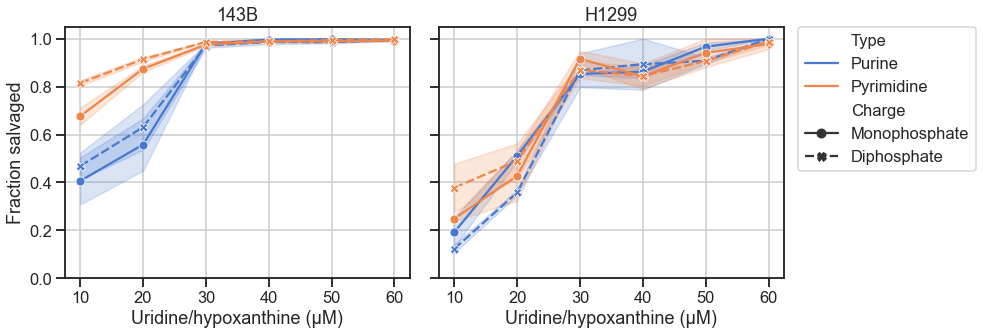

In [13]:
# Plot salvage fraction broken down as
# calculated from mono or diphosphate:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# First plot 143B data:
g1 = sns.lineplot(ax=ax1, data=df_143B, x='Conc', y='Salvage fraction', hue='Type', style='Charge', markers=True, dashes=True)
g1.grid(True)
g1.set_ylim([0, 1.05])
g1.set_ylabel('Fraction salvaged');
g1.set_xlabel('Uridine/hypoxanthine (μM)');
g1.set_title('143B')
g1.legend_.remove()

# Second plot for H1299:
g2 = sns.lineplot(ax=ax2, data=df_H1299, x='Conc', y='Salvage fraction', hue='Type', style='Charge', markers=True, dashes=True)
g2.grid(True)
g2.set_ylabel('Fraction salvaged');
g2.set_xlabel('Uridine/hypoxanthine (μM)');
g2.set_title('H1299')

# Add legend:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, ncol=1)

fig.tight_layout()
fig.savefig('output/Uridine-Hypoxanthine_salvage-fraction_combined.pdf')

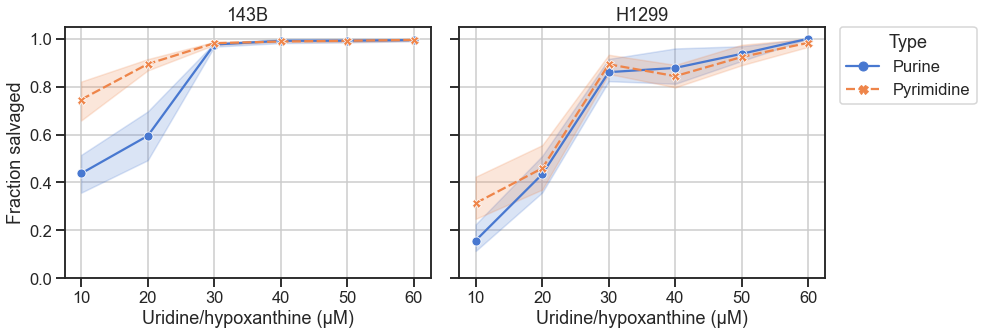

In [14]:
# Plot salvage fraction:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# First, plot 143B:
g1 = sns.lineplot(ax=ax1, data=df_143B, x='Conc', y='Salvage fraction', hue='Type', style='Type', markers=True, dashes=True)
g1.grid(True)
g1.set_ylim([0, 1.05])
g1.set_ylabel('Fraction salvaged');
g1.set_xlabel('Uridine/hypoxanthine (μM)');
g1.set_title('143B')
g1.legend_.remove()

# Second, plot H1299:
g2 = sns.lineplot(ax=ax2, data=df_H1299, x='Conc', y='Salvage fraction', hue='Type', style='Type', markers=True, dashes=True)
g2.grid(True)
g2.set_ylabel('Fraction salvaged');
g2.set_xlabel('Uridine/hypoxanthine (μM)');
g2.set_title('H1299')

# Add legend:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, ncol=1)

fig.tight_layout()
fig.savefig('output/Uridine-Hypoxanthine_salvage-fraction_combined_no-charge.pdf')

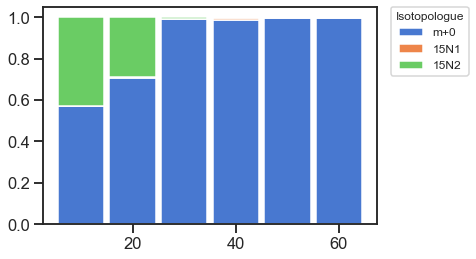

In [15]:
# Example for plotting isotopologues distribution:
isotopologues = ['m+0', '15N1', '15N2']
r = df_isotopes_143B['Conc'].values
bars = df_isotopes_143B['AMP 15N0 ratio'].values
plot_objs = []
p = plt.bar(r, bars, edgecolor='white', width=9)
plot_objs.append(p)
bars_next = df_isotopes_143B['AMP 15N1 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)
bars = bars + bars_next
bars_next = df_isotopes_143B['AMP 15N2 ratio'].values
p = plt.bar(r, bars_next, bottom=bars, edgecolor='white', width=9)
plot_objs.append(p)

plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);